In [10]:
# Import the libraries for the data quality step
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import interactive
from ipywidgets import Layout, FileUpload
from IPython.display import Markdown, display
import io
import os
import random
import datetime
import seaborn as sns
from IPython.display import clear_output
from pathlib import Path

def printmd(string):
    display(Markdown(string))

# Data collection

### Direct upload

In [2]:
# ----- For testing purposes ------
file_path = "./Datasets/dementiadatacollectionoctober2014csv15kb.csv"
data = pd.read_csv(file_path)

### Use the upload button

In [3]:
# Shows the upload widget
upload = FileUpload(accept='.csv')
upload

FileUpload(value={}, accept='.csv', description='Upload')

In [4]:
try:
    uploaded_filename = next(iter(upload.value))
    content = upload.value[uploaded_filename]['content']
    data = pd.read_csv(io.BytesIO(content), header=0, escapechar='\\', encoding= 'unicode_escape')
except StopIteration:
    printmd("#### Please enter a valid file.**")

#### Please enter a valid file.**

### Dataset preview 

In [ ]:
data.head()

# General dataset metadata

In [11]:
print("\u0332".join("Descriptive metadata\n"))
filename, file_extension = os.path.splitext(file_path)
file_extension = file_extension.replace(".", "")
file_path_obj = Path(file_path)
last_modified = file_path_obj.stat().st_mtime

print("Format: {}".format(file_extension))
print("Size: {} elements".format(data.size))
print("Last modified: {}\n".format(datetime.datetime.fromtimestamp(last_modified)))


print("\u0332".join("Structural metadata\n"))
print("All column names: {}\n".format(list(data.columns)))
# data.isna().sum() is needed because the count function only returns the total number of non-na elements
print("Total number of values for each column: \n\n{} ".format(data.count() + data.isna().sum()))



D̲e̲s̲c̲r̲i̲p̲t̲i̲v̲e̲ ̲m̲e̲t̲a̲d̲a̲t̲a̲

Format: csv
Size: 1650 elements
Last modified: 2021-02-05 14:16:34.047817

S̲t̲r̲u̲c̲t̲u̲r̲a̲l̲ ̲m̲e̲t̲a̲d̲a̲t̲a̲

All column names: ['Org name', 'Org code', ' Number of cases identified ', ' Number of emergency admissions ', 'Percentage of cases identified', ' Number of cases with diagnostic assessment  ', ' Number of cases with positive case finding question ', 'Percentage of cases with diagnostic assessment', 'Number of cases referred', 'Number of cases with positive or inconclusive diagnostic assessment', 'Percentage of cases referred']

Total number of values for each column: 

Org name                                                               150
Org code                                                               150
 Number of cases identified                                            150
 Number of emergency admissions                                        150
Percentage of cases identified                                      

# Values distribution for a specific column

In [12]:
# Unique values for each column
df_features = pd.DataFrame(index = data.columns)
df_features['Total_Values'] = list(map(lambda x: data[x].count(), data.columns))
df_features['Unique_Values'] = list(map(lambda x: data[x].value_counts().count(), data.columns))
df_features['Most_Frequent_Value'] = list(map(lambda x: data[x].value_counts().sort_values(ascending = False).index[0], data.columns))
df_features['Most_Frequent_Value_Count'] = list(map(lambda x: data[x].value_counts().sort_values(ascending = False).iloc[0], data.columns))
df_features['Type_Data'] = list(map(lambda x: data[x].dtype, data.columns))

def compute_values_dist_column(column_name):
    plt.figure(figsize=(20,5))
    if df_features['Unique_Values'][column_name] > 100:
         fig = px.histogram(data, y=column_name,
                            color_discrete_sequence =['#d595e8'],
                            barmode="group",
                            title="Values distribution for column '{}'".format(column_name)).update_yaxes(categoryorder="total ascending")
    else:
         fig = px.histogram(data, y=column_name,
                            color_discrete_sequence =['#d595e8'],
                            barmode="group", 
                            title="Values distribution for column '{}'".format(column_name)).update_yaxes(categoryorder="total ascending")
    fig.show()

w = widgets.Dropdown(options = data.columns, description="Column: ", value = None)
def on_change(change):
    with outs:
        clear_output(wait=True)
        if change['type'] == 'change' and change['name'] == 'value':
            print(" ----- Values distribution histogram for %s -----" % change['new'])
            compute_values_dist_column(change['new'])

outs = widgets.Output()
w.observe(on_change, names='value')
display(w)
display(outs)

# Clean up
with outs:
    clear_output()


Dropdown(description='Column: ', options=('Org name', 'Org code', ' Number of cases identified ', ' Number of …

Output()

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

#  Unique values for a specific column

In [13]:
def get_unique_values(req_data, req_column):
    return pd.Series(req_data[req_column].value_counts())

def unique_values_dist_column(unique_values, column_name):
    try:
        plt.figure(figsize=(20,5))
        fig = px.bar(unique_values, x=column_name,
                           color_discrete_sequence =['#d595e8'],
                           barmode="group",
                           title="Unique values for column '{}'".format(column_name)).update_yaxes(categoryorder="total ascending")
        fig.show()
    except KeyError:
        printmd("## Please select a column.")
    except IndexError:
        printmd("## Please select a column.")
        
def on_change(change):
    with outs:
        clear_output(wait=True)
        if change['type'] == 'change' and change['name'] == 'value':
            print(" ------ Unique values of %s -----" % change['new'])
            unique_values = get_unique_values(data, change['new']).to_frame()
            unique_values.iloc[:, ::-1]
            unique_values_dist_column(unique_values, change['new'])

outs = widgets.Output()
w = widgets.Dropdown(options = data.columns, description="Column: ", value = None)
w.observe(on_change, names='value')
display(w)
display(outs)

# Clean up
with outs:
    clear_output()

Dropdown(description='Column: ', options=('Org name', 'Org code', ' Number of cases identified ', ' Number of …

Output()

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

# Assessing the plausibility of the dataset

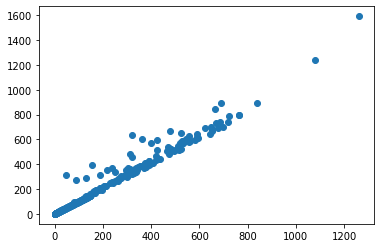

In [14]:
# Correlation test - determines the present and extent of a linear relationship between 2 quantitative variables
# the number of cases identified are closely related to the number of emergency admissions
# 
# This can be observed through the presence of the linear relationship between them.
#
# The data should be cleaned before doing the correlation test
def cleanNullTerms(d):
   return {
      k:v if v != 'NIL RETURN' and not pd.isnull(v) else '0'
      for k, v in d.items()
   }

cases = cleanNullTerms(data[' Number of cases identified '])
admissions = cleanNullTerms(data[' Number of emergency admissions '])

plt.scatter(cases.items(), admissions.items())
plt.show()